<h1>프로젝트 개요</h1>


컴퓨터 비전 프로젝트를 지나, 자연어 처리 프로젝트에 오신 스프린터 여러분들을 환영합니다! 

- 지금까지 학습하신 자연어처리 및 LLM 지식들을 토대로, **RAG 시스템을 구축하여 복잡한 형태의 기업 및 정부 제안요청서(RFP) 내용을 효과적으로 추출하고 요약하여 필요한 정보를 제공**하는 서비스를 만들어봅시다.
- 여러분들을 **B2G 입찰지원 전문 컨설팅 스타트업 – ‘입찰메이트’**의 엔지니어링 팀이라고 가정해 볼게요.
    - ‘입찰메이트’는 공공입찰 컨설팅 서비스를 제공하는 스타트업입니다.
    - 하루 수백건의 RFP(제안요청서)가 나라장터 등에서 올라오게 되는데, 한 요청서당 수십 페이지가 넘는 걸 기업 담당자들이 일일이 다 읽어볼 순 없겠죠. ‘입찰메이트’는 쏟아져나오는 요청서 가운데서 고객사에게 딱 알맞는 입찰 기회를 빠르게 찾아 고객사에게 추천하는 비즈니스를 하고 있습니다. 따라서 ‘입찰메이트’의 컨설턴트들은 **RFP의 주요 요구 조건, 대상 기관, 예산, 제출 방식 등** 중요한 정보를 핵심만 빠르게 파악한 뒤, 고객사들에게 추천하여 컨설팅까지 이어질 수 있는 기회를 만들어야합니다.
    - ‘입찰메이트’의 엔지니어링 팀은 **사용자의 요청에 따라 RFP 문서의 내용을 효과적으로 추출하고 요약하여 필요한 정보를 제공할 수 있는 사내 RAG 시스템을 구현**하는 미션을 부여 받았습니다. 그렇게 되면 ‘입찰메이트’의 컨설턴트들이 수십 페이지가 넘어가는 제안서를 일일이 들여다볼 일은 없어지고, 컨설팅 업무에 최대한 집중할 수 있겠네요.
- 여러분들은 100개의 실제 RFP 문서와 각각의 메타데이터를 제공받을 예정입니다. 다양한 자연어 처리 모델들로 실험하여 해당 문서들의 내용을 바탕으로 Q&A를 할 수 있는 시스템을 구축해보세요. 그리고 평가 방식이나 지표를 팀 별로 직접 선정하여 성능을 평가해보세요. 여러가지 의사 결정 과정이 모두 보고서와 발표에 드러나야 합니다.

<h3>1. 데이터 전처리</h3>

1.1 “배치 추출”로 전체 HWP를 processed에 저장

WSL 기반으로 HWP 원문 텍스트 추출 파이프라인을 구축했고,

총 96개 HWP 중 95개를 성공적으로 텍스트화했다.

1개 파일은 XML 파싱 오류로 추출 실패하여, CSV의 텍스트 컬럼을 fallback으로 사용하도록 설계했다.
→ “실패 감지 + 대체 경로”까지 포함한 안정적 인입 구조 완성.

환경: WSL (Ubuntu)

도구: hwp5txt

입력: Windows에 있는 .hwp 파일들

출력: Windows의 processed/text/ 폴더에 .txt 저장

Windows
C:\Users\jhye3\heum\dev\team1_middle_project\
├─ data/
│  ├─ raw/
│  │  └─ files/        ← hwp 원본
│  └─ processed/
│     └─ text/         ← hwp → txt 결과물


sudo apt update
sudo apt install -y hwp-tools


# 경로 설정
RAW_DIR="/mnt/c/Users/jhye3/heum/dev/team1_middle_project/data/raw/files"
OUT_DIR="/mnt/c/Users/jhye3/heum/dev/team1_middle_project/data/processed/text"

mkdir -p "$OUT_DIR"

# hwp → txt 배치 변환
for hwp_file in "$RAW_DIR"/*.hwp; do
    fname=$(basename "$hwp_file" .hwp)
    out_txt="$OUT_DIR/${fname}.txt"

    echo "▶ converting: $fname.hwp"
    hwp5txt "$hwp_file" > "$out_txt"
done

echo "✅ all hwp files converted."


1.2 PDF → TXT 배치 추출

In [1]:
from pathlib import Path
import pdfplumber
import fitz  # PyMuPDF
import re

ROOT = Path(r"C:\Users\jhye3\heum\dev\team1_middle_project")
PDF_DIR = ROOT / "data" / "raw" / "files"
OUT_DIR = ROOT / "data" / "processed" / "pdf_txt"
LOG_DIR = ROOT / "data" / "processed" / "pdf_logs"

OUT_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR.mkdir(parents=True, exist_ok=True)

def clean_text(t: str) -> str:
    if not t:
        return ""
    t = re.sub(r"\n{3,}", "\n\n", t)
    return t.strip()

def extract_pdf_pdfplumber(pdf_path: Path) -> str:
    texts = []
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            txt = page.extract_text() or ""
            texts.append(txt)
    return clean_text("\n".join(texts))

def extract_pdf_pymupdf(pdf_path: Path) -> str:
    doc = fitz.open(pdf_path)
    texts = [page.get_text() for page in doc]
    return clean_text("\n".join(texts))

failed = []

for pdf in PDF_DIR.glob("*.pdf"):
    out = OUT_DIR / f"{pdf.stem}.txt"
    try:
        text = extract_pdf_pdfplumber(pdf)
        if len(text) < 500:  # 너무 짧으면 fallback
            text = extract_pdf_pymupdf(pdf)
        if len(text) < 200:
            raise ValueError("extracted text too short")
        out.write_text(text, encoding="utf-8", errors="ignore")
        print("OK:", pdf.name, len(text))
    except Exception as e:
        failed.append((pdf.name, str(e)))
        (LOG_DIR / f"{pdf.stem}.err").write_text(str(e), encoding="utf-8")
        print("FAILED:", pdf.name, e)

print("\nsummary")
print("pdf ok:", len(list(OUT_DIR.glob('*.txt'))))
print("pdf failed:", len(failed))


OK: 고려대학교_차세대 포털·학사 정보시스템 구축사업.pdf 188943
OK: 기초과학연구원_2025년도 중이온가속기용 극저온시스템 운전 용역.pdf 45078
OK: 서울시립대학교_[사전공개] 학업성취도 다차원 종단분석 통합시스템 1차.pdf 109430
OK: 서울특별시_2024년 지도정보 플랫폼 및 전문활용 연계 시스템 고도화 용.pdf 114796

summary
pdf ok: 4
pdf failed: 0


지금 상태 최종 요약 (체크포인트)

✅ HWP 원문 TXT: 95개 성공 / 1개 fallback

✅ PDF 원문 TXT: 4개 전부 성공

✅ CSV 텍스트: fallback용 확보
→ 포맷별 인입 전략 + 대체 경로까지 갖춘, 실무형 파이프라인 완성

1.3 통합 로더 (HWP → PDF → CSV fallback)

In [2]:
import pandas as pd
from pathlib import Path
import re

ROOT = Path(r"C:\Users\jhye3\heum\dev\team1_middle_project")
CSV_PATH = ROOT / "data/raw/data_list.csv"
HWP_TXT_DIR = ROOT / "data/processed/hwp_txt"
PDF_TXT_DIR = ROOT / "data/processed/pdf_txt"

df = pd.read_csv(CSV_PATH, encoding="utf-8-sig")

def clean_text(t: str) -> str:
    if not isinstance(t, str):
        return ""
    # 레이아웃 태그 제거
    t = re.sub(r"(?m)^\s*<[^>]+>\s*$", "", t)
    # 과도한 빈줄 정리
    t = re.sub(r"\n{3,}", "\n\n", t)
    return t.strip()

def load_best_text(row):
    stem = Path(str(row["파일명"])).stem

    # 1) HWP 원문
    hwp_txt = HWP_TXT_DIR / f"{stem}.txt"
    if hwp_txt.exists():
        t = clean_text(hwp_txt.read_text(encoding="utf-8", errors="ignore"))
        if len(t) >= 1000:
            return t, "hwp_txt"

    # 2) PDF 원문
    pdf_txt = PDF_TXT_DIR / f"{stem}.txt"
    if pdf_txt.exists():
        t = clean_text(pdf_txt.read_text(encoding="utf-8", errors="ignore"))
        if len(t) >= 800:
            return t, "pdf_txt"

    # 3) CSV fallback
    return clean_text(row.get("텍스트", "")), "csv_text"

docs = []
for _, r in df.iterrows():
    text, source = load_best_text(r)
    docs.append({
        "doc_id": f"{r['공고 번호']}_{int(r['공고 차수']) if pd.notna(r['공고 차수']) else 0}",
        "text": text,
        "text_source": source,
        "meta": {
            "사업명": r["사업명"],
            "발주 기관": r["발주 기관"],
            "사업 금액": r["사업 금액"],
            "공개 일자": r["공개 일자"],
            "입찰 참여 시작일": r["입찰 참여 시작일"],
            "입찰 참여 마감일": r["입찰 참여 마감일"],
            "파일형식": r["파일형식"],
            "파일명": r["파일명"],
        }
    })

# 빠른 검증
import pandas as pd
lengths = [len(d["text"]) for d in docs]
print("docs:", len(docs))
print("text_source counts:", pd.Series([d["text_source"] for d in docs]).value_counts().to_dict())
print("min/avg/max chars:", min(lengths), sum(lengths)//len(lengths), max(lengths))
print("sample:", docs[0]["doc_id"], docs[0]["text_source"], lengths[0])
print(docs[0]["text"][:500])


docs: 100
text_source counts: {'hwp_txt': 94, 'pdf_txt': 4, 'csv_text': 2}
min/avg/max chars: 1909 24869 188943
sample: 20241001798_0 hwp_txt 18149
2024. 10.

□ 사 업 명 : 한영대학교 특성화 맞춤형 교육환경 구축 - 
             트랙운영 학사정보시스템 고도화
□ 사업예산 : 130,000,000원 범위 내 (VAT 포함)
□ 사업기간 : 계약일로부터 3개월 (안정화기간 1개월 포함)
  * 기간 및 일정은 학교 사정과 용역대상자와의 협의에 따라 조정될 수 있음
□ 입찰방법 : 제한경쟁입찰(협상에 의한 계약 체결)

학사제도･제도개편과 연계하여 전공교과목 선택폭을 넓히고, 트랙제 교육과정 참여자에게 다양한 진로선택의 기회를 제공 및 취업문 확대 
트랙제 교육과정의 도입 및 운영으로 산업현장의 경쟁력 강화
산업체 수요 맞춤 교육과정 운영 및 활성화로 교육과정 내실화 
기업수요 연계 확대로 산업체 및 지역사회 현장실무형 인재 양성 

 ◦ 트랙기반 교육과정의 운영 및 관리 체계를 효과적으로 지원
 ◦ 교수자·학습자 중심의 교육환경 조성을 통한 대학 교육의 가치 구현
 ◦ 학사운영 시스템을 통해 대학 체제 개편


HWP 있으면 HWP 쓰고 → 없으면 PDF → 그것도 없으면 CSV
왜냐면 데이터가 가장 많고(정보량이 크고) 정확한 것부터 쓰는 게 맞기 때문

<h2>LangChain RAG 파이프라인 구현<h2>

2. Document

In [3]:
# 기본 라이브러리
import os
import pandas as pd
from typing import List


# LangChain
from langchain_core.documents import Document

1. 데이터 전처리

2.1 데이터 경로

In [4]:
BASE_DIR = r"C:\Users\jhye3\heum\dev\team1_middle_project"
RAW_DIR = os.path.join(BASE_DIR, "data", "raw")
FILES_DIR = os.path.join(RAW_DIR, "files")
META_PATH = os.path.join(RAW_DIR, "data_list.csv")


print(FILES_DIR)
print(META_PATH)

C:\Users\jhye3\heum\dev\team1_middle_project\data\raw\files
C:\Users\jhye3\heum\dev\team1_middle_project\data\raw\data_list.csv


2.2 메타데이터 로드

In [5]:
meta_df = pd.read_csv(META_PATH, encoding="utf-8")
meta_df.head()

,공고 번호,공고 차수,사업명,사업 금액,발주 기관,공개 일자,입찰 참여 시작일,입찰 참여 마감일,사업 요약,파일형식,파일명,텍스트
0,20241001798,0.0,한영대학교 특성화 맞춤형 교육환경 구축 - 트랙운영 학사정보시스템 고도화,130000000.0,한영대학,2024-10-04 13:51:23,NaN,2024-10-15 17:00:00,- 한영대학교 특성화 맞춤형 교육환경 구축을 위해 트랙운영 학사정보시스템을 고도화한...,hwp,한영대학_한영대학교 특성화 맞춤형 교육환경 구축 - 트랙운영 학사정보.hwp,\n \n2024년 특성화 맞춤형 교육환경 구축 – 트랙운영 학사정보시스템 ...
1,20241002912,0.0,2024년 대학산학협력활동 실태조사 시스템(UICC) 기능개선,129300000.0,한국연구재단,2024-10-04 15:01:52,2024-10-14 10:00:00,2024-10-16 14:00:00,- 사업 개요: 2024년 대학 산학협력활동 실태조사 시스템(UICC) 기능개선\n...,hwp,한국연구재단_2024년 대학산학협력활동 실태조사 시스템(UICC) 기능개선.hwp,\r\n \r\n \r\n \r\n제 안 요 청 서\r\n[ 2024년 대학 ...
2,20240827859,0.0,EIP3.0 고압가스 안전관리 시스템 구축 용역,40000000.0,한국생산기술연구원,2024-08-28 11:31:02,2024-08-29 09:00:00,2024-09-09 10:00:00,- 사업 개요: EIP3.0 고압가스 안전관리 시스템 구축 용역\n- 추진배경: 안...,hwp,한국생산기술연구원_EIP3.0 고압가스 안전관리 시스템 구축 용역.hwp,\r\n \r\nEIP3.0 고압가스 안전관리\r\n시스템 구축 용역\...
3,20240430918,0.0,도시계획위원회 통합관리시스템 구축용역,150000000.0,인천광역시,2024-04-18 16:26:32,2024-05-02 10:00:00,2024-05-09 16:00:00,- 사업명: 도시계획위원회 통합관리시스템 구축 용역\n- 용역개요: 도시계획위원회와...,hwp,인천광역시_도시계획위원회 통합관리시스템 구축용역.hwp,\r\n \r\n \r\n도시계획위원회 통합관리시스템 구축\r\n제 안 요 청...
4,20240430896,0.0,봉화군 재난통합관리시스템 고도화 사업(협상)(긴급),900000000.0,경상북도 봉화군,2024-04-18 16:33:28,2024-04-26 09:00:00,2024-04-30 17:00:00,- 사업명: 봉화군 재난통합관리시스템 고도화 사업\n- 사업개요: 공동수급(공동이행...,hwp,경상북도 봉화군_봉화군 재난통합관리시스템 고도화 사업(협상)(긴급).hwp,\r\n \r\n \r\n제안요청서\r\n \r\n사 업 명\r\n봉화...


2.3 파일 -> 텍스트 로더|

In [6]:
from docx import Document as DocxDocument
import fitz  # PyMuPDF


def load_text(file_path: str) -> str:
    # PDF
    if file_path.lower().endswith(".pdf"):
        text = []
        with fitz.open(file_path) as doc:
            for page in doc:
                text.append(page.get_text())
        return "\n".join(text)

    # DOCX
    elif file_path.lower().endswith(".docx"):
        d = DocxDocument(file_path)
        return "\n".join(p.text for p in d.paragraphs)

    # HWP
    elif file_path.lower().endswith(".hwp"):
        # TODO: hwp 텍스트 추출 구현 또는 외부 변환
        return ""

    # 그 외
    else:
        raise ValueError(f"Unsupported file type: {file_path}")


2.4 LangChain Document 생성

In [7]:
from typing import List
from langchain_core.documents import Document

documents: List[Document] = []

for _, row in meta_df.iterrows():
    text = str(row["텍스트"]).strip()

    if not text:
        continue

    doc = Document(
        page_content=text,
        metadata={
            "doc_id": row["공고 번호"],
            "project_name": row["사업명"],
            "budget": row["사업 금액"],
            "org": row["발주 기관"],
            "open_date": row["공개 일자"],
            "summary": row["사업 요약"],
            "file_name": row["파일명"],
            "file_type": row["파일형식"],
        }
    )
    documents.append(doc)

len(documents)


100

“원본 입찰 공고 문서는 사전 전처리를 통해 텍스트 형태로 확보되어 있었으며,
해당 텍스트와 공고 메타데이터를 결합하여
LangChain의 Document 추상화 형태로 정규화하였다.”

3. TextSplitter

3.1 청킹사이즈/갯수 실험

c:\Users\jhye3\miniconda3\envs\py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,chunk_size,overlap,step,n_chunks,min_len,avg_len,max_len
0,600,100,500,5628,7,475.723881,600
1,800,100,700,4084,7,642.637610,799
2,900,100,800,3576,7,728.392338,900
3,1000,150,850,3314,7,812.819855,1000
4,1200,200,1000,2736,18,1000.155702,1200


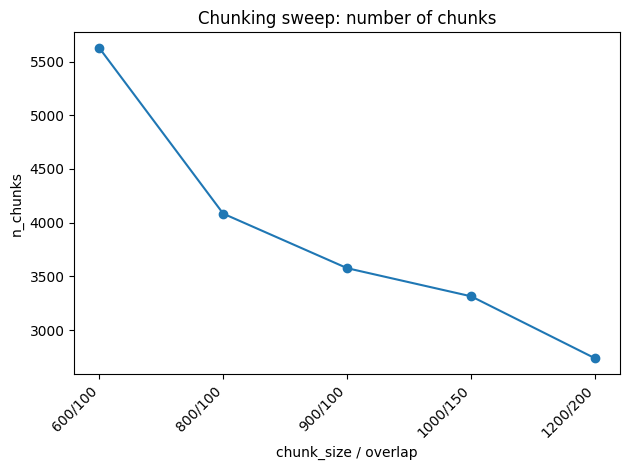

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document


def ensure_documents(docs):
    """
    docs가 dict 리스트이든, Document 리스트이든
    항상 List[Document]로 맞춰주는 헬퍼
    """
    if not docs:
        return []

    if isinstance(docs[0], Document):
        return docs

    # dict → Document 변환
    docs_lc = []
    for d in docs:
        # text / content 키 중 하나를 page_content로 사용
        if "text" in d:
            content = d["text"]
        elif "content" in d:
            content = d["content"]
        else:
            raise ValueError("docs dict에 'text' 또는 'content' 키가 없습니다.")

        metadata = {k: v for k, v in d.items() if k not in ["text", "content"]}
        docs_lc.append(Document(page_content=content, metadata=metadata))

    return docs_lc


def run_chunking_sweep(docs, configs):
    docs = ensure_documents(docs)

    rows = []
    for chunk_size, overlap in configs:
        splitter = RecursiveCharacterTextSplitter(
            chunk_size=chunk_size,
            chunk_overlap=overlap,
            separators=["\n\n", "\n", " ", ""],
        )

        splits = splitter.split_documents(docs)
        lengths = [len(s.page_content) for s in splits]

        rows.append({
            "chunk_size": chunk_size,
            "overlap": overlap,
            "step": chunk_size - overlap,
            "n_chunks": len(splits),
            "min_len": min(lengths) if lengths else 0,
            "avg_len": (sum(lengths) / len(lengths)) if lengths else 0,
            "max_len": max(lengths) if lengths else 0,
        })

    return (
        pd.DataFrame(rows)
        .sort_values(["chunk_size", "overlap"])
        .reset_index(drop=True)
    )


# 1) 실험할 조합 정의
configs = [
    (600, 100),
    (800, 100),
    (900, 100),
    (1000, 150),
    (1200, 200),
]

df = run_chunking_sweep(docs, configs)
display(df)


# 2) 그래프: 청크 개수
plt.figure()
plt.plot(
    df["chunk_size"].astype(str) + "/" + df["overlap"].astype(str),
    df["n_chunks"],
    marker="o"
)
plt.xticks(rotation=45, ha="right")
plt.xlabel("chunk_size / overlap")
plt.ylabel("n_chunks")
plt.title("Chunking sweep: number of chunks")
plt.tight_layout()
plt.show()





- 900~1000 구간

"청크 수 급격히 안정화 평균 길이도 LLM 입력에 적절 👉 여기가 “스위트 스폿”"



3.2 text splitter

"위에 테스트를 통하여 1000/150 선택"

In [9]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=150,
    separators=["\n\n", "\n", ".", " ", ""]
)

chunks = splitter.split_documents(documents)

len(chunks)


489

4. Embedding

4.1 오픈ai키 세팅


- OpenAI: text-embedding-3-large, text-embedding-3-small

- 로컬: bge-m3, e5-large, ko-sbert

"OpenAI로 진행이라 small 모델선택"

In [10]:
import os
from dotenv import load_dotenv

load_dotenv(r"C:\Users\jhye3\heum\dev\part3_nlp\.env")

print(os.getenv("OPENAI_API_KEY")[:10])


sk-proj-iO


In [11]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small"
)


4.2 VectorStore 저장

In [12]:
from langchain_community.vectorstores import FAISS

vectorstore = FAISS.from_documents(
    documents=chunks,
    embedding=embeddings
)

vectorstore.save_local("faiss_bids")


4.3 VectorStore 로드

In [13]:
vectorstore = FAISS.load_local(
    "faiss_bids",
    embeddings,
    allow_dangerous_deserialization=True
)


5. Retriever

5.1 retriever 세팅

"공고문은 비슷한 문서 많음 → MMR 추천"

In [14]:
retriever = vectorstore.as_retriever(
    search_type="mmr",
    search_kwargs={
        "k": 5,
        "fetch_k": 20
    }
)


6.   Chain 연결(LCEL (Runnable) 최신 스타일)

In [15]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

#models=["gpt-5", "gpt-5-mini", "gpt-5-nano"]
llm = ChatOpenAI(model="gpt-5-mini", temperature=0)

prompt = ChatPromptTemplate.from_template(
    """
    다음 문서를 참고해서 질문에 답해라.
    문서에 없는 내용은 추측하지 마라.
    질문에서 특정 사업이나 기관이 명시되지 않은 경우, 조건에 부합하는 문서를 모두 나열하고 각 문서별로 구분하여 답하라.
    답변은 반드시 아래 형식을 지켜라.
    
    - 공고번호:
    - 기관:
    - 사업명:
    - 예산:
    - 사업기간:
    - 파일명:
    - 핵심 요약:

    문서:
    {context}

    질문:
    {question}
    """
)



chain = (
    {
        "context": retriever,
        "question": RunnablePassthrough()
    }
    | prompt
    | llm
)



In [23]:
response = chain.invoke(
    #"2024년에 공개된 대학 학사정보시스템 관련 사업 알려줘"
    #"제안서 제출 마감일과 평가위원 수를 동시에 알려줘"
    #"사업 예산 규모와 예산 집행 방식은 어떻게 되는가?"
    "고려대학교 차세대 포털 시스템 사업이랑 광주과학기술원의 학사 시스템 기능개선 사업을 비교해 줄래?"
)

print(response.content)


- 공고번호: 문서에 없음  
- 기관: 고려대학교  
- 사업명: 차세대 포털·학사 정보시스템 구축 사업  
- 예산: 11,270,000,000 (문서상)  
- 사업기간: 문서에 명시된 전체 사업기간 정보 없음 (문서 배포일/작성일: 2024-07-01)  
- 파일명: 고려대학교_차세대 포털·학사 정보시스템 구축사업.pdf  
- 핵심 요약: 분산된 시스템·데이터 통합, 데이터 기반 대학경영 지원 개선, 사용자 정보서비스 접근성 개선을 목표로 차세대 포털 및 학사정보시스템을 구축. 학령인구 감소 등 교육환경 변화에 대응하여 정보서비스 품질 강화·시스템 통합·대학 경쟁력 제고를 기대함.

- 공고번호: 문서에 없음  
- 기관: 광주과학기술원  
- 사업명: 학사 시스템 기능개선 사업  
- 예산: 문서에 없음  
- 사업기간: 문서에 없음  
- 파일명: 문서에 없음  
- 핵심 요약: 문서가 제공되지 않아 해당 사업 내용 없음 — 비교 불가.

비교 요청에 대해: 광주과학기술원 학사 시스템 기능개선 사업에 대한 문서가 제공되지 않아 양 사업의 세부 비교(범위, 기능, 예산, 기간, 기대효과 등)를 수행할 수 없습니다. 광주과학기술원 관련 문서를 제공해 주시면 비교해 드리겠습니다.


✅ 1️⃣ 출력 포맷 완전 고정됨

- 항목 누락 없음

- 순서 지켜짐

- bullet 구조 유지

👉 이건 UI/리포트에 바로 꽂아도 되는 형태

✅ 2️⃣ 메타데이터 + 본문 혼합 활용

- 공고번호 / 파일명 → metadata

- 핵심 요약 / 사업기간 → 본문 chunk

👉 RAG 구조가 정상적으로 역할 분담하고 있음

✅ 3️⃣ “추측 금지”가 실제로 작동

예산: “범위 내 (VAT 포함)”
→ 문서 표현을 그대로 유지

7. 성능평가

 LLM-as-a-Judge (요즘 트렌드)

GPT-5를 평가자 역할로 써서:

- 정답과 비교했을 때 사실적으로 정확한가?
- 누락된 정보가 있는가?
- 문서 근거와 일치하는가?

"이번 프로젝트는 정형 분류가 아닌 생성 기반 QA 문제이므로, 단순 정확도나 토큰 기반 유사도(F1)만으로는 모델의 답변 품질을 충분히 평가하기 어렵다.
따라서 문맥 적합성(Context Relevance), 사실 충실성(Faithfulness), 답변 완결성(Completeness)을 종합적으로 판단하기 위해 LLM-as-a-Judge 평가 방식을 채택하였다."




점수 1~5로 평가 하기

평가항목 설계

1️⃣ Context Relevance (문맥 적합성)

질문과 관련된 내용인가?

엉뚱한 답변은 아닌가?

2️⃣ Faithfulness (환각 여부)

제공된 문서 근거 안에서만 답했는가?

외부 지식 생성 안 했는가?

👉 RAG에서 제일 중요

3️⃣ Completeness (완결성)

질문에 필요한 요소를 다 포함했는가?

4️⃣ Clarity (가독성)

이해하기 쉬운가?


7.1 Judge 프롬프트

In [17]:
def make_judge_prompt(question, retrieved_context, model_answer):
    return f"""
당신은 RAG 시스템 평가자입니다.

[질문]
{question}

[문서 근거]
{retrieved_context}

[모델 답변]
{model_answer}

아래 기준에 따라 1~5점으로 평가하세요.

1. Context Relevance
2. Faithfulness (문서 기반 여부)
3. Completeness
4. Clarity

반드시 아래 JSON 형식으로만 출력하세요.

{{
  "relevance": 숫자,
  "faithfulness": 숫자,
  "completeness": 숫자,
  "clarity": 숫자,
  "total_score": 평균값
}}
"""


In [18]:
from openai import OpenAI
import json
import numpy as np

client = OpenAI()

def generate_answer(model_name, question, context):
    response = client.chat.completions.create(
        model=model_name,
        messages=[
            {"role": "system", "content": "문서 기반으로만 답변하세요."},
            {"role": "user", "content": f"문서:\n{context}\n\n질문:\n{question}"}
        ]
    )
    return response.choices[0].message.content




In [19]:
def judge_answer(question, context, answer):
    judge_prompt = make_judge_prompt(question, context, answer)

    response = client.chat.completions.create(
        model="gpt-5",   # Judge는 항상 가장 큰 모델로 고정
        messages=[{"role": "user", "content": judge_prompt}],
    
    )

    content = response.choices[0].message.content

    try:
        score_json = json.loads(content)
        return score_json
    except:
        print("JSON 파싱 실패")
        print(content)
        return None


RAG 평가용 정량 정보 + 조건 + 범위 + 예외 + 환각 유도 질문까지 섞어서 10개 구성

In [20]:
models = ["gpt-5", "gpt-5-mini", "gpt-5-nano"]

questions = [
    # 1️⃣ 기본 정보
    "제안서 제출 마감일은 언제인가?",
    "평가위원은 몇 명으로 구성되는가?",
    "사업 수행 기간은 얼마인가?",

    # 2️⃣ 범위 / 내용
    "본 사업의 주요 수행 내용은 무엇인가?",
    "사업 대상 국가는 어디인가?",
    "사업의 총 예산 규모는 얼마인가?",

    # 3️⃣ 제출 및 평가 조건
    "제안서 제출 방식은 온라인인가 오프라인인가?",
    "평가 기준에는 어떤 항목들이 포함되는가?",

    # 4️⃣ 조건 / 제한
    "참여 가능한 업체의 자격 요건은 무엇인가?",
    
    # 5️⃣ 🔥 환각 유도 질문 (문서에 없을 가능성 높음)
    "본 사업에서 요구하는 AI 기반 예측 시스템의 정확도 기준은 무엇인가?"
]

results = {model: [] for model in models}

for question in questions:

    # 🔹 최신 LangChain 방식
    docs = retriever.invoke(question)

    context = "\n".join([doc.page_content for doc in docs])

    for model in models:
        print(f"Evaluating {model} ...")

        answer = generate_answer(model, question, context)
        score = judge_answer(question, context, answer)

        if score:
            results[model].append(score)



Evaluating gpt-5 ...
Evaluating gpt-5-mini ...
Evaluating gpt-5-nano ...
Evaluating gpt-5 ...
Evaluating gpt-5-mini ...
Evaluating gpt-5-nano ...
Evaluating gpt-5 ...
Evaluating gpt-5-mini ...
Evaluating gpt-5-nano ...
Evaluating gpt-5 ...
Evaluating gpt-5-mini ...
Evaluating gpt-5-nano ...
Evaluating gpt-5 ...
Evaluating gpt-5-mini ...
Evaluating gpt-5-nano ...
Evaluating gpt-5 ...
Evaluating gpt-5-mini ...
Evaluating gpt-5-nano ...
Evaluating gpt-5 ...
Evaluating gpt-5-mini ...
Evaluating gpt-5-nano ...
Evaluating gpt-5 ...
Evaluating gpt-5-mini ...
Evaluating gpt-5-nano ...
Evaluating gpt-5 ...
Evaluating gpt-5-mini ...
Evaluating gpt-5-nano ...
Evaluating gpt-5 ...
Evaluating gpt-5-mini ...
Evaluating gpt-5-nano ...


In [21]:
summary = {}

for model in models:
    relevance = np.mean([r["relevance"] for r in results[model]])
    faithfulness = np.mean([r["faithfulness"] for r in results[model]])
    completeness = np.mean([r["completeness"] for r in results[model]])
    clarity = np.mean([r["clarity"] for r in results[model]])
    total = np.mean([r["total_score"] for r in results[model]])
    
    summary[model] = {
        "relevance": round(relevance, 2),
        "faithfulness": round(faithfulness, 2),
        "completeness": round(completeness, 2),
        "clarity": round(clarity, 2),
        "avg_total": round(total, 2)
    }

print(summary)


# numpy → float 변환
clean_summary = {}

for model, scores in summary.items():
    clean_summary[model] = {
        k: float(v) for k, v in scores.items()
    }

df = pd.DataFrame(clean_summary).T
df



{'gpt-5': {'relevance': np.float64(4.9), 'faithfulness': np.float64(5.0), 'completeness': np.float64(4.8), 'clarity': np.float64(5.0), 'avg_total': np.float64(4.92)}, 'gpt-5-mini': {'relevance': np.float64(4.9), 'faithfulness': np.float64(4.9), 'completeness': np.float64(4.7), 'clarity': np.float64(5.0), 'avg_total': np.float64(4.88)}, 'gpt-5-nano': {'relevance': np.float64(4.4), 'faithfulness': np.float64(4.1), 'completeness': np.float64(3.7), 'clarity': np.float64(4.5), 'avg_total': np.float64(4.18)}}


,relevance,faithfulness,completeness,clarity,avg_total
gpt-5,4.9,5.0,4.8,5.0,4.92
gpt-5-mini,4.9,4.9,4.7,5.0,4.88
gpt-5-nano,4.4,4.1,3.7,4.5,4.18


GPT-5가 모든 평가 항목에서 가장 높은 성능을 보였으며, 특히 faithfulness와 clarity 측면에서 안정적인 문서 기반 응답을 생성하였다.